## Imports

In [1]:
#from data_classes import LAQNData, HealthData, MetData, IncomeData
import pandas as pd
import matplotlib.pyplot as plt

# Imports for classes
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
from os import path, listdir, environ
import wandb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from copy import deepcopy

## Config

In [83]:
config = {
    "architecture": "MLP_regressor",
    "train_size": 0.7,
    "val_size": 0.15, # Set MLP configs
    "hidden_layer_sizes": [10],
    "batch_size": 30, # to False
    "num_epochs": 100, # if using
    "learning_rate": 0.001, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "met_variables": ["temperature"] # Set to False if excluding meteorology
    }

torch.manual_seed(1)

## Code

In [58]:
# Metrics function. Move to model classes script when finished.

def mape_score(targets, predictions):
        zero_indices = np.where(targets == 0)
        targets_drop_zero = np.delete(targets, zero_indices)
        prediction_drop_zero = np.delete(predictions, zero_indices)
        mape = np.sum(np.abs(targets_drop_zero - prediction_drop_zero)/targets_drop_zero) * 100/len(targets_drop_zero)
        return mape

In [59]:
# To be moved to model_classes script when finished developing.

class MLPRegression():
    def __init__(self, hidden_layer_sizes, output_layer_size=1):
        self.hl_sizes = hidden_layer_sizes
        self.out_sizes = output_layer_size
        # Initialise the MLPArchitecture class
        self.model = MLPArchitecture(self.hl_sizes, self.out_sizes)
        self.metrics_functions = {"r2": r2_score, "mse": mean_squared_error, "mape": mape_score}
        
    def fit(self, x_train, y_train, x_val, y_val, batch_size, num_epochs, learning_rate, noise_standard_deviation=False):
        # Training code that loops through epochs
        model = self.model
        
        training_dataset = MLPDataset(x_train, y_train, noise_std=noise_standard_deviation)
        validation_dataset = MLPDataset(x_val, y_val)

        training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
        validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
        
        criterion = nn.MSELoss()
        optimiser = Adam(model.parameters(), lr=learning_rate)
        
        wandb.watch(model, criterion, log="all", log_freq=10)
        
        training_loss_history = []
        validation_loss_history = []
        metrics_scores = {}

        for epoch in tqdm(range(num_epochs)):
            # Training set
            model.train()
            loss_sum = 0  # for storing
            y_pred_epoch = np.zeros_like(y_train)

            for batch_num, data in enumerate(training_dataloader):
                inputs_training = data["inputs"]
                targets_training = data["targets"]
                optimiser.zero_grad()

                # Run the forward pass
                y_predict = model(inputs_training)
                y_pred_epoch[batch_num*batch_size : (batch_num+1)*batch_size] = np.squeeze(y_predict.detach().numpy())
                # Compute the loss and gradients
                single_loss = criterion(y_predict, targets_training)
                single_loss.backward()
                # Update the parameters
                optimiser.step()

                # Calculate loss for storing
                loss_sum += single_loss.item()*data["targets"].shape[0]  # Account for different batch size with final batch

            training_loss_history.append(loss_sum / len(training_dataset))  # Save the training loss after every epoch
            
            # Do the same for the validation set
            model.eval()
            validation_loss_sum = 0
            y_pred_val_epoch = np.zeros_like(y_val)
            with torch.no_grad():
                for batch_num, data in enumerate(validation_dataloader):
                    inputs_val = data["inputs"]
                    targets_val = data["targets"]
                    y_predict_validation = model(inputs_val)
                    y_pred_val_epoch[batch_num*batch_size : (batch_num+1)*batch_size] = np.squeeze(y_predict_validation.detach().numpy())
                    single_loss = criterion(y_predict_validation, targets_val)
                    validation_loss_sum += single_loss.item()*data["targets"].shape[0]
                    
            for metric in ["r2", "mse", "mape"]:
                metrics_scores.update({f"{metric}_train": self.metrics_functions[metric](y_train, y_pred_epoch)})
                metrics_scores.update({f"{metric}_val": self.metrics_functions[metric](y_val, y_pred_val_epoch)})
                
            # Store the model with smallest validation loss. Check if the validation loss is the lowest BEFORE
            # saving it to loss history (otherwise it will not be lower than itself)
            if (not validation_loss_history) or validation_loss_sum / len(validation_dataset) < min(validation_loss_history):
                self.best_model = deepcopy(model)
                best_epoch = epoch
                best_metrics = metrics_scores.copy()
           
            validation_loss_history.append(validation_loss_sum / len(validation_dataset))  # Save the val loss every epoch.


            wandb.log({"training_loss": loss_sum / len(training_dataset),
                      "validation_loss": validation_loss_sum / len(validation_dataset), 
                      "r2_train": metrics_scores["r2_train"],
                      "r2_val": metrics_scores["r2_val"],
                      "mean_squared_error_train": metrics_scores["mse_train"],
                      "mean_squared_error_val": metrics_scores["mse_val"],
                      "mean_absolute_percentage_error_train": metrics_scores["mape_train"],
                       "mean_absolute_percentage_error_val": metrics_scores["mape_val"]
                      },
                      step=epoch)
            
#                 # Save the model every 2 epochs
#             if epoch % 2 == 0:
#                 torch.save({
#                     "total_epochs": epoch,
#                     "final_state_dict": model.state_dict(),
#                     "optimiser_state_dict": optimiser.state_dict(),
#                     "training_loss_history": training_loss_history,
#                     "best_state_dict": best_model.state_dict(),
#                     "best_epoch": best_epoch,
#                     "validation_loss_history": validation_loss_history,
#                 }, save_path)

        
        wandb.log({"best_epoch": best_epoch, 
                   "best_r_squared_train": best_metrics["r2_train"],
                   "best_r_squared_val": best_metrics["r2_val"],
                   "best_mean_squared_error_train": best_metrics["mse_train"],
                   "best_mean_squared_error_val": best_metrics["mse_val"],
                   "best_mean_absolute_percentage_error_train": best_metrics["mape_train"],
                   "best_mean_absolute_percentage_error_val": best_metrics["mape_val"]
                  })
        
        return  self.best_model, best_epoch
    
    def evaluate(self, checkpoint, x_test, y_test, batch_size, noise_standard_deviation=False):
        model = self.model
        model.load_state_dict(checkpoint["state_dict"])
        epoch = checkpoint["epoch"]
        
        test_dataset = MLPDataset(x_test, y_test, noise_std=False)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
        
        metrics_scores = {}
        
        model.eval()
        y_predict = np.zeros_like(y_test)
        with torch.no_grad():
            for batch_num, data in enumerate(test_dataloader):
                inputs = data["inputs"]
                targets = data["targets"]
                outputs = model(inputs)
                y_predict[batch_num*batch_size : (batch_num+1)*batch_size] = np.squeeze(outputs.detach().numpy())
                
        for metric in ["r2", "mse", "mape"]:
            metrics_scores.update({f"{metric}_test": self.metrics_functions[metric](y_test, y_predict)})
    
        wandb.log({"r2_test": metrics_scores["r2_test"],
                   "mean_squared_error_test": metrics_scores["mse_test"],
                   "mean_absolute_percentage_error_test": metrics_scores["mape_test"]})
        
    
    def predict(self, checkpoint, x, y, batch_size):
        model = self.model
        model.load_state_dict(checkpoint["state_dict"])
        dataset = MLPDataset(x, y, noise_std=False)
        dataloader = DataLoader(dataset, batch_size=batch_size)
               
        model.eval()
        y_predict = np.zeros_like(y)
        with torch.no_grad():
            for batch_num, data in enumerate(dataloader):
                inputs = data["inputs"]
                targets = data["targets"]
                outputs = model(inputs)
                y_predict[batch_num*batch_size : (batch_num+1)*batch_size] = np.squeeze(outputs.detach().numpy())
        return y_predict
        
    
class MLPArchitecture(nn.Module):
    def __init__(self, hl_sizes, out_size):
        super(MLPArchitecture, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hl_sizes)-1):
            self.hidden_layers.append(nn.Linear(hl_sizes[i], hl_sizes[i + 1], bias=False))
        self.output_layer = nn.Linear(hl_sizes[-1], out_size)
        
    def forward(self, x):
        # Forward pass through each layer
        x = x.view(x.shape[0], x.shape[1])
        # Feedforward
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        return self.output_layer(x)
       
class MLPDataset(Dataset):
    def __init__(self, x, y, noise_std=False):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()[:, None]
        self.noise_std = noise_std  # Standard deviation of Gaussian noise

    def __len__(self):
        return self.x.size()[0]

    def nfeatures(self):
        return self.x.size()[-1]

    def __getitem__(self, index):
        x1 = self.x[index]
        y1 = self.y[index]
        if self.noise_std:
            noise = torch.randn_like(x1)*self.noise_std
            x1 = x1 + noise
        return {"inputs": x1, "targets": y1}

In [69]:
# To be moved to model_classes script when finished developing.

class HealthModel():
    def __init__(self, config):
        self.config = config
        self.architecture = config["architecture"]
        self.train_size = config["train_size"]
        self.val_size = config["val_size"]
        if config["met_variables"]:
            self.hidden_layer_sizes = [len(config["input_artifacts"])+len(config["met_variables"])-1] +config["hidden_layer_sizes"]
        else:
            self.hidden_layer_sizes = [len(config["input_artifacts"])] +config["hidden_layer_sizes"]
        self.batch_size = config["batch_size"]
        self.num_epochs = config["num_epochs"]
        self.learning_rate = config["learning_rate"]
        self.species = config["species"]
        self.spatial_resolution = config["spatial_resolution"]
        self.temporal_resolution = config["temporal_resolution"]
        self.input_artifacts = config["input_artifacts"]
        self.met_variables = config["met_variables"]

    def preprocess_and_log(self):
        with wandb.init(project="AQmortality", job_type="split-normalise-data") as run:
            df = pd.DataFrame()
            # use dataset artifacts
            for artifact in self.input_artifacts:
                data_artifact = run.use_artifact(f"{artifact}:latest")
                data_folder = data_artifact.download()
                if artifact == "met-resample":
                    for variable in self.met_variables:
                        file = f"{variable}.npz"
                        data = np.load(path.join(data_folder, file), allow_pickle=True)
                        if df.empty:
                            df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[variable])
                        else:
                            df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[variable]))
                else:
                    file = listdir(data_folder)[0]
                    data = np.load(path.join(data_folder, file), allow_pickle=True)
                    if df.empty:
                        df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[file.replace(".npz", "")])
                    else:
                        df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[file.replace(".npz", "")]))

            target_artifact = run.use_artifact("mortality-scaled:latest")
            target_folder = target_artifact.download()
            data = np.load(path.join(target_folder, "deaths.npz"), allow_pickle=True)
            df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"]*100000, columns=["deaths"]))
            df = df.dropna(axis=0)

            # make new train, validation and test artifacts for regional scale data
            if self.val_size:
                index = {"train": df.index[:int(len(df.index)*self.train_size)],
                         "validat": df.index[int(len(df.index)*self.train_size):int(len(df.index)*(self.train_size+self.val_size))],
                        "test": df.index[int(len(df.index)*(self.train_size+self.val_size)):]}
                subsets = ["train", "validat", "test"]
            else:
                index = {"train": df.index[:int(len(df.index)*self.train_size)],
                        "test": df.index[int(len(df.index)*self.train_size):]}
                subsets = ["train", "test"]
            
            scaler = MinMaxScaler()
            x_scaler = scaler.fit(df.loc[index["train"]].drop("deaths", axis=1)) # Fit the scaler only to the training set distribution
            for subset in subsets:
                x = x_scaler.transform(df.loc[index[subset]].drop("deaths", axis=1))
                y = df.loc[index[subset]]["deaths"].values
                z = df.loc[index[subset]].index
                subset_data = wandb.Artifact(
                            f"xy_{subset}", type="dataset",
                            description=f"Input features (normalised) and targets for {subset}ing set.",
                            metadata={"input_shape":x.shape,
                                     "target_shape":y.shape,
                                     "species": self.species,
                                      "spatial_resolution": self.spatial_resolution,
                                      "temporal_resolution": self.temporal_resolution,
                                      "input_artifacts": self.input_artifacts,
                                      "met_variables": self.met_variables})
                with subset_data.new_file(subset + ".npz", mode="wb") as file:
                    np.savez(file, x=x, y=y, z=z)
                run.log_artifact(subset_data)
                
    def read_data(self, artifact):
        with wandb.init(project="AQmortality", job_type="read-data") as run:
            data_artifact = run.use_artifact(f"{artifact}:latest")
            data_folder = data_artifact.download()
            file = artifact.replace("xy_", "") + ".npz"
            data = np.load(path.join(data_folder, file), allow_pickle=True)
        return data["x"], data["y"]
    
    def train_and_log(self):
        model_type = self.architecture.replace("_", "-")
        data_dict = {}
        with wandb.init(project="AQmortality", job_type="train-regional-model", config=self.config) as run:
            if self.val_size:
                subsets = ["train", "validat"]
            else:
                subsets = ["train"]
            for subset in subsets:
                data_artifact = run.use_artifact(f"xy_{subset}:latest")
                data_folder = data_artifact.download()
                file = f"{subset}.npz"
                data = np.load(path.join(data_folder, file), allow_pickle=True)
                data_dict.update({"x_"+subset: data["x"], "y_"+subset: data["y"]})
            if model_type == "linear-regressor":
                regressor = LinearRegression().fit(data_dict["x_train"], data_dict["y_train"])
                data_dict.update({"y_predict": regressor.predict(data_dict["x_train"])})
                wandb.log({"r_squared": r2_score(data_dict["y_train"], data_dict["y_predict"]),
                       "mean_squared_error": mean_squared_error(data_dict["y_train"], data_dict["y_predict"]),
                       "mean_absolute_percentage_error": mape_score(data_dict["y_train"], data_dict["y_predict"])
                      })
            elif model_type == "MLP-regressor":
                regressor, epoch = MLPRegression(self.hidden_layer_sizes).fit(data_dict["x_train"], data_dict["y_train"], 
                                                                              data_dict["x_validat"], data_dict["y_validat"], 
                                                                              self.batch_size, self.num_epochs, self.learning_rate)
        # log trained model artifact – include input features description
            model = wandb.Artifact(
                            f"{model_type}", type="model",
                            description=f"{model_type} model.",
                            metadata={"input_shape":data_dict["x_train"].shape,
                                      "target_shape":data_dict["y_train"].shape,
                                      "layer_sizes": self.hidden_layer_sizes,
                                      "species": self.species,
                                      "spatial_resolution": self.spatial_resolution,
                                      "temporal_resolution": self.temporal_resolution,
                                      "input_artifacts": self.input_artifacts,
                                      "met_variables": self.met_variables
                                      })
            if model_type == "linear-regressor":
                with model.new_file("model.sav", mode="wb") as file:
                    joblib.dump(regressor, file)
            elif model_type == "MLP-regressor":
                with model.new_file("model.tar", mode="wb") as file:
                    torch.save({"state_dict": regressor.state_dict(),
                    "epoch": epoch}, file)
            run.log_artifact(model)
    
    
    def test_and_log(self):
        model_type = self.architecture.replace("_", "-")
        with wandb.init(project="AQmortality", job_type="test-regional-model", config=self.config) as run:
            data_dict = {}
            if self.val_size:
                subsets = ["train", "validat", "test"]
            else:
                subsets = ["train", "test"]
            for subset in subsets:
                data_artifact = run.use_artifact(f"xy_{subset}:latest")
                data_folder = data_artifact.download()
                file = f"{subset}.npz"
                data = np.load(path.join(data_folder, file), allow_pickle=True)
                data_dict.update({"x_"+subset: data["x"], "y_"+subset: data["y"], subset+"_dates": data["z"]})
            # use trained model artifact
            model_artifact = run.use_artifact(f"{model_type}:latest")
            model_folder = model_artifact.download()
            if model_type == "linear-regressor":
                regressor = joblib.load(path.join(model_folder, "model.sav"))
                for subset in subsets:
                    data_dict.update({f"y_{subset}_predict": regressor.predict(data_dict[f"x_{subset}"])})
    
                wandb.log({"r_squared": r2_score(data_dict["y_test"], data_dict["y_test_predict"]), 
                           "mean_squared_error": mean_squared_error(data_dict["y_test"], data_dict["y_test_predict"]), 
                           "mean_absolute_percentage_error": mape_score(data_dict["y_test"], data_dict["y_test_predict"])
                          })
            elif model_type == "MLP-regressor":
                regressor = MLPRegression(self.hidden_layer_sizes)
                checkpoint = torch.load(path.join(model_folder, "model.tar"))
                regressor.evaluate(checkpoint, data_dict["x_test"], data_dict["y_test"], self.batch_size)
                for subset in subsets:
                    data_dict.update({f"y_{subset}_predict": regressor.predict(checkpoint, data_dict[f"x_{subset}"], data_dict[f"y_{subset}"], self.batch_size)})
        return data_dict

In [84]:
model = HealthModel(config)

In [85]:
model.preprocess_and_log()

wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [86]:
model.train_and_log()

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


training_loss,0.05345
validation_loss,0.08646
r2_train,-0.59436
r2_val,-1.15401
mean_squared_error_train,0.19819
mean_squared_error_val,0.11581
mean_absolute_percentage_error_train,18.97475
mean_absolute_percentage_error_val,16.08482
_runtime,35
_timestamp,1622205791
_step,99


training_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▂█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂
r2_train,▁▇██████████████████████████████████████
r2_val,▇▁▆▇██▇▇▇▇▇▇▇▇███████████████████▇████▇▇
mean_squared_error_train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error_val,▂█▃▂▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂
mean_absolute_percentage_error_train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_percentage_error_val,▂█▄▂▂▂▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [87]:
data_dict = model.test_and_log()

r2_test,0.25286
mean_squared_error_test,0.03437
mean_absolute_percentage_error_test,9.24915
_runtime,21
_timestamp,1622205819
_step,0


r2_test,▁
mean_squared_error_test,▁
mean_absolute_percentage_error_test,▁
_runtime,▁
_timestamp,▁
_step,▁


In [88]:
df = pd.DataFrame()
if config["val_size"]:
    subsets = ["train", "validat", "test"]
else:
    subsets = ["train", "test"]
for subset in subsets:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"], "predicted":data_dict[f"y_{subset}_predict"]})
    if df.empty:
        df = subset_df.copy()
    else:
        df = df.append(subset_df)

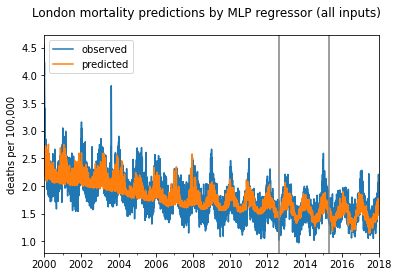

In [91]:
df.plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
if config["val_size"]:
    plt.axvline(data_dict["validat_dates"].max(), color="grey")
plt.legend()
plt.ylabel("deaths per 100,000")
model_title = config["architecture"].replace("_", " ")
plt.suptitle(f"London mortality predictions by {model_title} (all inputs)")
plt.show()